# New keywords

### Create dataset from current audio folder

In [1]:
import os
import tqdm
from pathlib import Path
import pandas as pd
import torchaudio
import librosa
import IPython.display as ipd
import numpy as np
from sklearn.model_selection import train_test_split
from datasets import load_dataset, load_metric
import torch
from transformers import AutoModelForAudioClassification, TrainingArguments, Trainer
import random
from IPython.display import Audio, display
from transformers import AutoFeatureExtractor
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from transformers import AutoConfig, Wav2Vec2Processor

import librosa
import IPython.display as ipd
import numpy as np
import pandas as pd


PATH_TO_AUDIO = "google_speech_recognition_v2"

/home/guillaume/anaconda3/envs/semproj/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

dataset = load_dataset("speech_commands", "v0.02")

Found cached dataset speech_commands (/home/guillaume/.cache/huggingface/datasets/speech_commands/v0.02/0.2.0/ba3d9a6cf49aa1313c51abe16b59203451482ccb9fee6d23c94fecabf3e206da)
100%|██████████| 3/3 [00:00<00:00, 31.44it/s]


In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'label', 'is_unknown', 'speaker_id', 'utterance_id'],
        num_rows: 84848
    })
    validation: Dataset({
        features: ['file', 'audio', 'label', 'is_unknown', 'speaker_id', 'utterance_id'],
        num_rows: 9982
    })
    test: Dataset({
        features: ['file', 'audio', 'label', 'is_unknown', 'speaker_id', 'utterance_id'],
        num_rows: 4890
    })
})

In [4]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

id2label

{'0': 'yes',
 '1': 'no',
 '2': 'up',
 '3': 'down',
 '4': 'left',
 '5': 'right',
 '6': 'on',
 '7': 'off',
 '8': 'stop',
 '9': 'go',
 '10': 'zero',
 '11': 'one',
 '12': 'two',
 '13': 'three',
 '14': 'four',
 '15': 'five',
 '16': 'six',
 '17': 'seven',
 '18': 'eight',
 '19': 'nine',
 '20': 'bed',
 '21': 'bird',
 '22': 'cat',
 '23': 'dog',
 '24': 'happy',
 '25': 'house',
 '26': 'marvin',
 '27': 'sheila',
 '28': 'tree',
 '29': 'wow',
 '30': 'backward',
 '31': 'forward',
 '32': 'follow',
 '33': 'learn',
 '34': 'visual',
 '35': '_silence_'}

In [5]:
for _ in range(5):
    rand_idx = random.randint(0, len(dataset["train"])-1)
    example = dataset["train"][rand_idx]
    audio = example["audio"]

    print(f'Label: {id2label[str(example["label"])]}')
    print(f'Shape: {audio["array"].shape}, sampling rate: {audio["sampling_rate"]}')
    display(Audio(audio["array"], rate=audio["sampling_rate"]))
    print()

Label: six
Shape: (16000,), sampling rate: 16000



Label: zero
Shape: (16000,), sampling rate: 16000



Label: right
Shape: (16000,), sampling rate: 16000



Label: off
Shape: (16000,), sampling rate: 16000



Label: yes
Shape: (16000,), sampling rate: 16000


In [6]:
model_checkpoint = "facebook/wav2vec2-base"
batch_size = 16

In [7]:
feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)
feature_extractor

/home/guillaume/anaconda3/envs/semproj/lib/python3.9/site-packages/transformers/configuration_utils.py:379: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0.0,
  "return_attention_mask": false,
  "sampling_rate": 16000
}

In [8]:
max_duration = 1.0 # seconds

In [9]:
def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays, 
        sampling_rate=feature_extractor.sampling_rate, 
        max_length=int(feature_extractor.sampling_rate * max_duration), 
        truncation=True, 
    )
    return inputs

In [10]:
encoded_dataset = dataset.map(preprocess_function, remove_columns=["audio", "file", "is_unknown", "speaker_id", "utterance_id"], batched=True)
encoded_dataset

Loading cached processed dataset at /home/guillaume/.cache/huggingface/datasets/speech_commands/v0.02/0.2.0/ba3d9a6cf49aa1313c51abe16b59203451482ccb9fee6d23c94fecabf3e206da/cache-0223cd6a50de7ce0.arrow
Loading cached processed dataset at /home/guillaume/.cache/huggingface/datasets/speech_commands/v0.02/0.2.0/ba3d9a6cf49aa1313c51abe16b59203451482ccb9fee6d23c94fecabf3e206da/cache-1cc507e9e6b45855.arrow
Loading cached processed dataset at /home/guillaume/.cache/huggingface/datasets/speech_commands/v0.02/0.2.0/ba3d9a6cf49aa1313c51abe16b59203451482ccb9fee6d23c94fecabf3e206da/cache-16589ea50785eea4.arrow


DatasetDict({
    train: Dataset({
        features: ['label', 'input_values'],
        num_rows: 84848
    })
    validation: Dataset({
        features: ['label', 'input_values'],
        num_rows: 9982
    })
    test: Dataset({
        features: ['label', 'input_values'],
        num_rows: 4890
    })
})

## Training

In [16]:
num_labels = len(id2label)
model = AutoModelForAudioClassification.from_pretrained(
    model_checkpoint, 
    num_labels=num_labels,
    label2id=label2id,
    id2label=id2label,
)


NameError: name 'id2label' is not defined

In [25]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-ks",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)

In [26]:
metric = load_metric("accuracy")

In [27]:
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [28]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics
)

In [29]:
torch.cuda.empty_cache()

In [30]:
trainer.train()

/home/guillaume/anaconda3/envs/semproj/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

  0%|          | 0/6625 [00:44<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 100.00 MiB (GPU 0; 3.82 GiB total capacity; 2.32 GiB already allocated; 74.31 MiB free; 2.62 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [32]:
trainer.evaluate()

100%|██████████| 218/218 [00:34<00:00,  6.29it/s]


{'eval_loss': 0.06069877743721008,
 'eval_accuracy': 0.9864981327204826,
 'eval_runtime': 34.8562,
 'eval_samples_per_second': 99.867,
 'eval_steps_per_second': 6.254,
 'epoch': 4.98}

In [ ]:
trainer.predict(encoded_dataset["test"])

## Inference

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_extractor_checkpoint = "facebook/wav2vec2-base"
audio_classification_checkpoint = "wav2vec2-base-finetuned-ks-32/checkpoint-3315"
feature_extractor = AutoFeatureExtractor.from_pretrained(feature_extractor_checkpoint)
config = AutoConfig.from_pretrained(feature_extractor_checkpoint)
sampling_rate = feature_extractor.sampling_rate
model = AutoModelForAudioClassification.from_pretrained(audio_classification_checkpoint).to(device)

c:\Users\eliot\anaconda3\envs\text2speech\lib\site-packages\transformers\configuration_utils.py:379: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [6]:
def speech_file_to_array_fn(path, sampling_rate):
    speech_array, _sampling_rate = torchaudio.load(path)
    resampler = torchaudio.transforms.Resample(_sampling_rate)
    speech = resampler(speech_array).squeeze().numpy()
    return speech


def predict(path, sampling_rate):
    speech = speech_file_to_array_fn(path, sampling_rate)
    features = feature_extractor(speech, sampling_rate=sampling_rate, return_tensors="pt", padding=True)

    input_values = features.input_values.to(device)
    # attention_mask = features.attention_mask.to(device)

    with torch.no_grad():
        logits = model(input_values).logits

    scores = F.softmax(logits, dim=1).detach().cpu().numpy()[0]
    outputs = scores
    # outputs = [{"Emotion": config.id2label[i], "Score": f"{round(score * 100, 3):.1f}%"} for i, score in enumerate(scores)]
    return outputs


STYLES = """
<style>
div.display_data {
    margin: 0 auto;
    max-width: 500px;
}
table.xxx {
    margin: 50px !important;
    float: right !important;
    clear: both !important;
}
table.xxx td {
    min-width: 300px !important;
    text-align: center !important;
}
</style>
""".strip()

def prediction(df_row):
    path, emotion = df_row["path"], df_row["emotion"]
    df = pd.DataFrame([{"Emotion": emotion, "Sentence": "    "}])
    setup = {
        'border': 2,
        'show_dimensions': True,
        'justify': 'center',
        'classes': 'xxx',
        'escape': False,
    }
    ipd.display(ipd.HTML(STYLES + df.to_html(**setup) + "<br />"))
    speech, sr = torchaudio.load(path)
    speech = speech[0].numpy().squeeze()
    speech = librosa.resample(np.asarray(speech), sr, sampling_rate)
    ipd.display(ipd.Audio(data=np.asarray(speech), autoplay=True, rate=sampling_rate))

    outputs = predict(path, sampling_rate)
    r = pd.DataFrame(outputs)
    ipd.display(ipd.HTML(STYLES + r.to_html(**setup) + "<br />"))

In [10]:
def list_devices():
    p = pyaudio.PyAudio()
    device_count = p.get_device_count()
    for i in range(0, device_count):
        info = p.get_device_info_by_index(i)
        print("Device {} = {}".format(info["index"], info["name"]))

list_devices()

Device 0 = Microsoft Sound Mapper - Input
Device 1 = Headset Microphone (HyperX Virt
Device 2 = VoiceMeeter Aux Output (VB-Audi
Device 3 = VoiceMeeter Output (VB-Audio Vo
Device 4 = Microphone (2- Aukey-PC-LM1E Au
Device 5 = VoiceMeeter VAIO3 Output (VB-Au
Device 6 = Microsoft Sound Mapper - Output
Device 7 = Headset Earphone (HyperX Virtua
Device 8 = C24F390 (NVIDIA High Definition
Device 9 = Realtek Digital Output (Realtek
Device 10 = VoiceMeeter Aux Input (VB-Audio
Device 11 = VoiceMeeter VAIO3 Input (VB-Aud
Device 12 = Haut-parleurs (Realtek(R) Audio
Device 13 = ROG PG278QR (NVIDIA High Defini
Device 14 = VoiceMeeter Input (VB-Audio Voi
Device 15 = Pilote de capture audio principal
Device 16 = Headset Microphone (HyperX Virtual Surround Sound)
Device 17 = VoiceMeeter Aux Output (VB-Audio VoiceMeeter AUX VAIO)
Device 18 = VoiceMeeter Output (VB-Audio VoiceMeeter VAIO)
Device 19 = Microphone (2- Aukey-PC-LM1E Audio)
Device 20 = VoiceMeeter VAIO3 Output (VB-Audio VoiceMeeter VAIO3)
De

In [14]:
# with pyaudio
import pyaudio
import wave
import tempfile
import os

CHUNK = 320  # number of audio samples per frame
FORMAT = pyaudio.paInt16  # audio format
CHANNELS = 1  # mono audio
RATE = 16000  # sampling rate in Hz
RECORD_SECONDS = 1  # duration of each recording in seconds
FILE_NAME = f"temp.wav"

def record_audio():
    p = pyaudio.PyAudio()

    stream = p.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=RATE,
                    input=True,
                    frames_per_buffer=CHUNK,
                    input_device_index=1)

    try:
        while True:
            frames = []  # to store audio frames

            for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
                data = stream.read(CHUNK)
                frames.append(data)

            # write frames to temporary WAV file
            
            wav_filename =  FILE_NAME
            wf = wave.open(wav_filename, 'wb')
            wf.setnchannels(CHANNELS)
            wf.setsampwidth(p.get_sample_size(FORMAT))
            wf.setframerate(RATE)
            wf.writeframes(b''.join(frames))
            wf.close()

            # read contents of WAV file a

            yield wav_filename

    except KeyboardInterrupt:
        pass

    stream.stop_stream()
    stream.close()
    p.terminate()

In [12]:
label2id.keys()

dict_keys(['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'bed', 'bird', 'cat', 'dog', 'happy', 'house', 'marvin', 'sheila', 'tree', 'wow', 'backward', 'forward', 'follow', 'learn', 'visual', '_silence_'])

In [17]:
for wav_data in record_audio():
    # pass the WAV data to your keyword spotter here
    label = predict(wav_data, 16000)
    max = np.argmax(label)
    print(f"most confident keyword = {id2label[str(max)]}, with a confiden of {label[max]}")
    

most confident keyword = two, with a confiden of 0.12397836148738861
most confident keyword = two, with a confiden of 0.060051415115594864
most confident keyword = happy, with a confiden of 0.20977216958999634
most confident keyword = up, with a confiden of 0.05424743890762329
most confident keyword = marvin, with a confiden of 0.9133039116859436
most confident keyword = learn, with a confiden of 0.2577916979789734
most confident keyword = up, with a confiden of 0.05803529918193817
most confident keyword = marvin, with a confiden of 0.9582083225250244
most confident keyword = nine, with a confiden of 0.11206689476966858
most confident keyword = up, with a confiden of 0.05772532522678375
most confident keyword = up, with a confiden of 0.05737100914120674
most confident keyword = stop, with a confiden of 0.9770510792732239
most confident keyword = up, with a confiden of 0.06299096345901489
most confident keyword = stop, with a confiden of 0.9557819962501526
most confident keyword = up, w

## Plot confusion matrix

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
audio_classification_checkpoint = "wav2vec2-base-finetuned-ks-32/checkpoint-3315"
model = AutoModelForAudioClassification.from_pretrained(audio_classification_checkpoint).to(device)

In [37]:
metric = load_metric("accuracy")

/tmp/ipykernel_5582/2588679507.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [38]:
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [39]:
model_name = "inference"

In [40]:
args = TrainingArguments(
    f"{model_name}-finetuned-ks-tehe",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)

In [41]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics
)

In [42]:
metrics = trainer.evaluate()

100%|██████████| 624/624 [01:37<00:00,  6.43it/s]


In [43]:
print(metrics)

{'eval_loss': 0.11561957746744156, 'eval_accuracy': 0.9764576237227008, 'eval_runtime': 97.2378, 'eval_samples_per_second': 102.656, 'eval_steps_per_second': 6.417}


In [33]:
model.eval()
true_label = []
predicted_label = []
for example in encoded_dataset["validation"]:
    true_label.append(example["label"])
    input_ids = torch.tensor(example["input_values"]).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(input_ids).logits
    scores = F.softmax(logits, dim=1).detach().cpu().numpy()[0]
    predicted_label.append(np.argmax(scores))


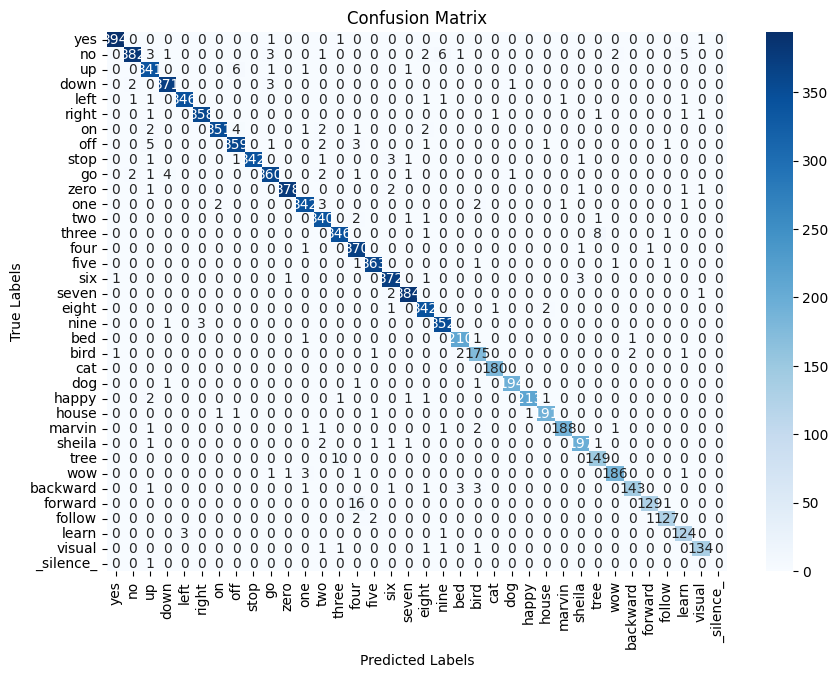

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(true_labels, predicted_labels, classes):
    cm = confusion_matrix(true_labels, predicted_labels)
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="d")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()


plot_confusion_matrix(true_label, predicted_label, list(label2id.keys()))
